Let's just get a quick sparsity overview of the methods so far.

In [10]:
import torch
from torch.utils.data import DataLoader

from torchvision import datasets
import torchvision.transforms as transforms


from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F

import numpy as np

from torchvision.utils import save_image

import matplotlib.pyplot as plt
import math

import gc

from utils import *

In [11]:
import os
from os import listdir

In [12]:
#BASE_PATH_DATA = '../data/'
BASE_PATH_DATA = '/scratch/ns3429/sparse-subset/data/'

In [13]:
n_epochs = 25
batch_size = 64
lr = 0.001
b1 = 0.9
b2 = 0.999
img_size = 28
channels = 1



z_size = 500
hidden_size = 1000

n = 28 * 28

# from running
# EPSILON = np.finfo(tf.float32.as_numpy_dtype).tiny
#EPSILON = 1.1754944e-38
EPSILON = 1e-10

In [14]:
cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

device = torch.device("cuda:0" if cuda else "cpu")

In [15]:
print("Device")
print(device)

Device
cpu


In [16]:
np.random.seed(100)

In [17]:
import scipy.io as sio

In [18]:
a = sio.loadmat(BASE_PATH_DATA + 'zeisel/zeisel_data.mat')
data= a['zeisel_data'].T
N,d=data.shape

In [19]:
for i in range(d):
    #data[i,:]=data[i,:]/np.linalg.norm(data[i,:])
    #mi = np.mean(data[:,i])
    #std = np.std(data[:,i])
    #data[:,i] = (data[:,i] - mi) / std
    ma = np.max(data[:,i])
    mi = np.min(data[:,i])
    data[:, i] = (data[:, i] - mi) / (ma - mi)

In [20]:
data[data!=0].min()

0.09018117926614051

In [21]:
input_size = d

In [22]:
slices = np.random.permutation(np.arange(data.shape[0]))
upto = int(.8 * len(data))

train_data = data[slices[:upto]]
test_data = data[slices[upto:]]

train_data = Tensor(train_data).to(device)
test_data = Tensor(test_data).to(device)

In [23]:
print(train_data.std(dim = 0).mean())
print(test_data.std(dim = 0).mean())

tensor(0.2263)
tensor(0.2223)


Does L1 work if we normalize after every step?

In [24]:
model_l1_diag = VAE_l1_diag(input_size, hidden_size, z_size)

model_l1_diag.to(device)
model_l1_optimizer = torch.optim.Adam(model_l1_diag.parameters(), 
                                            lr=lr,
                                            betas = (b1,b2))

In [25]:
for epoch in range(1, n_epochs + 1):
        train_l1(train_data, model_l1_diag, model_l1_optimizer, epoch, batch_size)
        test(test_data, model_l1_diag, epoch, batch_size)

Train Epoch: 1 [0/2404 (0%)]	Loss: 11413.724609
Train Epoch: 1 [1280/2404 (53%)]	Loss: 3157.709961
====> Epoch: 1 Average loss: 3709.6169
====> Test set loss: 2789.4660
Train Epoch: 2 [0/2404 (0%)]	Loss: 3056.877930


KeyboardInterrupt: 

In [ ]:
bins = [10**(-i) for i in range(10)]
bins.reverse()
bins += [10]
print(np.histogram(model_l1_diag.diag.abs().clone().detach().cpu().numpy(), bins = bins))

In [ ]:
quick_model_summary(model_l1_diag, train_data, test_data, 0.1, batch_size)

First try Pretrained VAE and then gumble trick with it

Then try joint training VAE and Gumbel Model

# Pretrain VAE First

In [15]:
pretrain_vae = VAE(input_size, hidden_size, z_size)

pretrain_vae.to(device)
pretrain_vae_optimizer = torch.optim.Adam(pretrain_vae.parameters(), 
                                            lr=lr,
                                            betas = (b1,b2))

In [16]:
for epoch in range(1, n_epochs + 1):
        train(train_data, pretrain_vae, pretrain_vae_optimizer, epoch, batch_size)
        test(test_data, pretrain_vae, epoch, batch_size)

Train Epoch: 1 [0/2404 (0%)]	Loss: 6447.793945
Train Epoch: 1 [1280/2404 (53%)]	Loss: 3060.293457
====> Epoch: 1 Average loss: 3516.2642


NameError: name 'np' is not defined

In [ ]:
quick_model_summary(pretrain_vae, train_data, test_data, 0.1, batch_size)

In [ ]:
for p in pretrain_vae.parameters():
    p.requires_grad = False

In [ ]:
pretrain_vae.requires_grad_(False)

## Train Gumbel with the Pre-Trained VAE

In [213]:
vae_gumbel_with_pre = VAE_Gumbel(input_size, hidden_size, z_size, k = 50)
vae_gumbel_with_pre.to(device)
vae_gumbel_with_pre_optimizer = torch.optim.Adam(vae_gumbel_with_pre.parameters(), 
                                                lr=lr, 
                                                betas = (b1,b2))

In [214]:
for epoch in range(1, n_epochs + 1):
        train_pre_trained(train_data, vae_gumbel_with_pre, vae_gumbel_with_pre_optimizer, 
                          epoch, pretrain_vae, batch_size)
        test(test_data, vae_gumbel_with_pre, epoch, batch_size)

Train Epoch: 1 [0/2404 (0%)]	Loss: 802522.687500
Train Epoch: 1 [1280/2404 (53%)]	Loss: 51021.445312
====> Epoch: 1 Average loss: 162977.3032
====> Test set loss: 6603.3549


In [217]:
quick_model_summary(vae_gumbel_with_pre, train_data, test_data, 0.1, batch_size)

tensor(1881, device='cuda:0')
tensor(1105, device='cuda:0')


# Joint Training

In [220]:
joint_vanilla_vae = VAE(input_size, hidden_size, z_size)
joint_vanilla_vae.to(device)

joint_vae_gumbel = VAE_Gumbel(input_size, hidden_size, z_size, k = 50)
joint_vae_gumbel.to(device)


joint_optimizer = torch.optim.Adam(list(joint_vanilla_vae.parameters()) + list(joint_vae_gumbel.parameters()), 
                                                lr=lr, 
                                                betas = (b1,b2))

In [221]:
for epoch in range(1, n_epochs + 1):
    train_joint(train_data, joint_vanilla_vae, joint_vae_gumbel, joint_optimizer, epoch, batch_size)
    test_joint(test_data, joint_vanilla_vae, joint_vae_gumbel, epoch, batch_size)

Train Epoch: 1 [0/2404 (0%)]	Loss: 1764689.125000
Train Epoch: 1 [1280/2404 (53%)]	Loss: 93686.765625
====> Epoch: 1 Average loss: 289752.5646
====> Test set loss: 20543.1331


In [224]:
quick_model_summary(joint_vae_gumbel, train_data, test_data, 0.1, batch_size)

tensor(1818, device='cuda:0')
tensor(1105, device='cuda:0')


In [ ]:
del joint_vanilla_vae

### Let's actually Graph this.

### Try it out at Gumbel sparsity of k = 10, 25, 50, 100, 250

### Graph Test MSE Loss

## Graph the mean activations at k = 50

In [67]:
def graph_activations(test_data, model, title, file):
    preds, _, _ = model(test_data)
    
    preds[preds < 0.09] = 0
    pred_activations = preds.mean(dim = 0)
    
    test_activations = test_data.mean(dim = 0)
    
    x = np.arange(input_size) + 1
    
    fig = plt.figure()
    plt.plot(x, pred_activations.clone().detach().cpu().numpy(), label = 'Average Predictions')
    plt.plot(x, test_activations.clone().detach().cpu().numpy(), label = 'Average Test Data')
    
    plt.title(title)
    plt.ylim([-0.1, 1])
    plt.xlabel("Feature Index")
    plt.ylabel("Average Activation of Feature")
    
    plt.legend()
    plt.savefig(file)

In [ ]:
def graph_sparsity(test_data, model, title, file):
    preds, _, _ = model(test_data)
    
    preds[preds < 0.09] = 0
    preds[preds >= 0.09] = 1
    
    pred_count = preds.sum(dim = 0) / len(test_data)
    
    test_count = test_data.sum(dim = 0) / len(test_data)
    
    x = np.arange(input_size) + 1
    
    fig = plt.figure()
    plt.plot(x, pred_count.clone().detach().cpu().numpy(), label = 'Count NonZero Predictions')
    plt.plot(x, test_count.clone().detach().cpu().numpy(), label = 'Count NonZero Test Data')
    
    plt.title(title)
    plt.ylim([-0.1, 1])
    plt.xlabel("Feature Index")
    plt.ylabel("Proportion of Test Set Feature Was not Sparse")
    
    plt.legend()
    plt.savefig(file)

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/ns3429/sparse-subset/vae_l1.png'

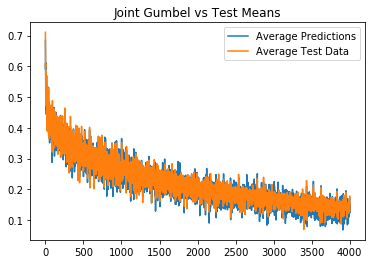

In [69]:
graph_activations(test_data, model_l1_diag, 'Joint Gumbel vs Test Means', 
                  '/scratch/ns3429/sparse-subset/vae_l1_activations.png')
graph_sparsity(test_data, model_l1_diag, 'Joint Gumbel vs Test Sparsity', 
                  '/scratch/ns3429/sparse-subset/vae_l1_sparsity.png')

del model_l1_diag

In [32]:
graph_activations(test_data, joint_vae_gumbel, 'Joint Gumbel vs Test Means', 
                  '/scratch/ns3429/sparse-subset/joint_gumbel_activations.png')
graph_sparsity(test_data, joint_vae_gumbel, 'Joint Gumbel vs Test Sparsity', 
                  '/scratch/ns3429/sparse-subset/joint_gumbel_sparsity.png')

del joint_vae_gumbel

NameError: name 'joint_vae_gumbel' is not defined

In [228]:
graph_activations(test_data, vae_gumbel_with_pre, 'Gumbel Matching Pretrained VAE vs Test Means', 
                  '/scratch/ns3429/sparse-subset/pretrained_gumbel_activations.png')
graph_sparsity(test_data, vae_gumbel_with_pre, 'Gumbel Matching Pretrained VAE vs Test Sparsity', 
                  '/scratch/ns3429/sparse-subset/pretrained_gumbel_sparsity.png')

del vae_gumbel_with_pre

RuntimeError: CUDA out of memory. Tried to allocate 38.00 MiB (GPU 0; 1.96 GiB total capacity; 1.19 GiB already allocated; 7.12 MiB free; 1.24 GiB reserved in total by PyTorch)

In [61]:
k_all = [5, 10, 25, 50, 75, 100, 150]#, 250, 500, 1000, 2000, 3000]
n_trials = 10

In [ ]:
losses_pre = []
losses_joint = []

In [ ]:
for k in k_all:
    current_k_pre_losses = []
    current_k_joint_losses = []
    for trial_i in range(n_trials):
        print("RUNNING for K {} Trial {}".format(k, trial_i), flush=True)
        vae_gumbel_with_pre = VAE_Gumbel(input_size, hidden_size, z_size, k = k)
        vae_gumbel_with_pre.to(device)
        vae_gumbel_with_pre_optimizer = torch.optim.Adam(vae_gumbel_with_pre.parameters(), 
                                                        lr=lr, 
                                                        betas = (b1,b2))
    
        joint_vanilla_vae = VAE(input_size, hidden_size, z_size)
        joint_vanilla_vae.to(device)

        joint_vae_gumbel = VAE_Gumbel(input_size, hidden_size, z_size, k = k)
        joint_vae_gumbel.to(device)


        joint_optimizer = torch.optim.Adam(list(joint_vanilla_vae.parameters()) + 
                                           list(joint_vae_gumbel.parameters()),
                                                lr=lr, 
                                                betas = (b1,b2))
    
        for epoch in (1, n_epochs + 1):
            train_pre_trained(train_data, vae_gumbel_with_pre, vae_gumbel_with_pre_optimizer, 
                              epoch, pretrain_vae, batch_size)
            train_joint(train_data, joint_vanilla_vae, joint_vae_gumbel, joint_optimizer, epoch, batch_size)
    
        test_loss_pre = 0
        test_loss_joint = 0
        
        inds = np.arange(test_data.shape[0])
        with torch.no_grad():
            for i in range(math.ceil(len(test_data)/batch_size)):
                batch_ind = inds[i * batch_size : (i+1) * batch_size]
                batch_data = test_data[batch_ind, :]
                
                test_pred_pre = vae_gumbel_with_pre(batch_data)[0]
                test_pred_joint = joint_vae_gumbel(batch_data)[0]
                
                test_pred_pre[test_pred_pre < 0.09] = 0
                test_pred_joint[test_pred_joint < 0.09] = 0
                
                test_loss_pre += F.binary_cross_entropy(test_pred_pre, batch_data, reduction='sum')
                test_loss_joint += F.binary_cross_entropy(test_pred_joint, batch_data, reduction='sum')
                
                del batch_data
            
        test_loss_pre /= len(test_df)
        test_loss_joint /= len(test_df)
        current_k_pre_losses.append(test_loss_pre.cpu().item())
        current_k_joint_losses.append(test_loss_joint.cpu().item())
        
        # for freeing memory faster
        del vae_gumbel_with_pre
        del vae_gumbel_with_pre_optimizer
        del joint_vanilla_vae
        del joint_vae_gumbel
        del joint_optimizer

        torch.cuda.empty_cache()
        
    
    losses_pre.append(np.mean(current_k_pre_losses))
    losses_joint.append(np.mean(current_k_joint_losses))
    
    
    
fig = plt.figure()
plt.plot(k_all, losses_pre, label = 'Average BCE Losses with Gumbel Matching Pretrained')
plt.plot(k_all, losses_joint, label = 'Average BCE Losses with Gumbel Joint Training')

plt.title("Effect on Sparsity on BCE Loss")
plt.xlabel('Sparsity Level (Number of Non-Zero Features)')
plt.ylabel('Per Neuron Average BCE Loss')
plt.legend()

plt.savefig('/scratch/ns3429/sparse-subset/comparing_across_sparsity.png')